# Figure Six: PFSS Model

- Panel (a_: Full Carrington EUV map with PFSS model overlaid
    - footpoints (grey, pink (FSW), green (SSW), purple (SASW))
    - trajectory (red (positive polarity), blue (negative polarity))
    - HCS (white)
    - footpoint radial magnetic field ($B_{r, \, 0}$)
- Bottom Panels: zoom in of top panel onto four periods of interest along with footpoint brightness
    - Panel (b): HCS crossing
    - Panel (c): FSW region
    - Panel (d): SSW & SASW regions

## Imports

In [9]:
import sys, os
import astropy.units as u

import datetime
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


import sunpy
import astrospice
from astropy.coordinates import SkyCoord

from tools.psp_funcs import ballistically_project

import astropy.units as u
import sunpy.coordinates as scoords
import tools.pfss_funcs as pfss_funcs

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
sacol = 'violet'
scol = 'lightgreen'
hcol = 'lightblue'
aa = 0.6
lw=2
clon = '#ae017e'
clat = '#085A99'
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring']

# REGIONS
loc_hcs = [113, 116]
ssw = [166, 175]
sasw = [175, 185]
fsw = [70, 85]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'

# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 18})
plt.style.use(plot_style)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

08-Jan-24 14:22:41: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Data

In [10]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, his_orbiter, his_orbiterdownt, his_orbiterdownl = utils.read_data(RES_DIR, sigma_time=20)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=sasw[0], lon_footpoints <=sasw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])


08-Jan-24 14:22:43: /Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Jan-24 14:22:43: /Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

08-Jan-24 14:22:46: /Users/tamarervin/publications/e11_ch/tools/utilities.py:189: FutureWarning: 'loffset' in .resample() and in Group

## Run PFSS Model

In [11]:
# download/read in magnetogram
rss=2.0
filename = 'adapt40311_03k012_202202240000_i00005600n1.fts.gz'
filepath = f"{STORAGE_DIR}/{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)
gong_map = sunpy.map.Map(adapt_magnetogram.data/1e5, adapt_magnetogram.meta)

# run PFSS model
pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss)

# trace PFSS lines
flines = pfss_funcs.pfss2flines(pfss_model)

08-Jan-24 14:22:51: Missing metadata for solar radius: assuming the standard radius of the photosphere.
08-Jan-24 14:22:51: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/sunpy/map/mapbase.py:633: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs

  obs_coord = self.observer_coordinate

08-Jan-24 14:22:51: Missing metadata for solar radius: assuming the standard radius of the photosphere.
08-Jan-24 14:22:51: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/sunpy/map/mapbase.py:633: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following met

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


08-Jan-24 14:22:55: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(



In [12]:
# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', parker.Time

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
psp_at_source_surface = ballistically_project(psp_carrington,vr_arr=parker.vr*u.km/u.s, r_inner=2.0*u.Rsun)

In [13]:
# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# get trajectory 
polarity = np.sign(parker.BrR2)
pos = np.where(polarity == 1)
neg = np.where(polarity == -1)

# get field lines
flines_psp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

# high res field lines
flines_highres = pfss_funcs.pfss2flines(pfss_model,nth=181,nph=361)

# get field line topology defined by polarity
topologies = flines_highres.polarities.reshape([181,361])

08-Jan-24 14:24:58: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(



# Figure 10: Noise in PFSS Results

In [6]:
### INDUCE NOISE IN THE PROPAGATION RESULT
field_lines_ss, ss_new_coords = [], []
for i in np.arange(5):
    lon_noise = np.random.uniform(-5, 5, len(psp_at_source_surface.lat.value))
    lat_noise = np.random.uniform(-5, 5, len(psp_at_source_surface.lat.value))

    # create new coordinates
    new_coords = SkyCoord(lon=psp_at_source_surface.lon+lon_noise*u.deg, lat=psp_at_source_surface.lat+lat_noise*u.deg, 
                           radius=psp_at_source_surface.radius, representation_type="spherical",
                          frame = psp_at_source_surface.frame)
    ss_new_coords.append(new_coords)
    field_lines_ss.append(pfss_funcs.pfss2flines(pfss_model, skycoord_in=new_coords))

### INDUCE NOISE IN VELOCITY 
source_surface, field_lines, velocity = [], [], []
for i in np.arange(5):
    noise = np.random.uniform(-20, 20, len(parker.vr))
    vel = parker.vr + noise
    source_surface.append(ballistically_project(psp_carrington,vr_arr=vel*u.km/u.s, r_inner=2.0*u.Rsun))
    field_lines.append(pfss_funcs.pfss2flines(pfss_model, skycoord_in=source_surface[i]))
    velocity.append(vel)

22-Nov-23 16:13:35: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


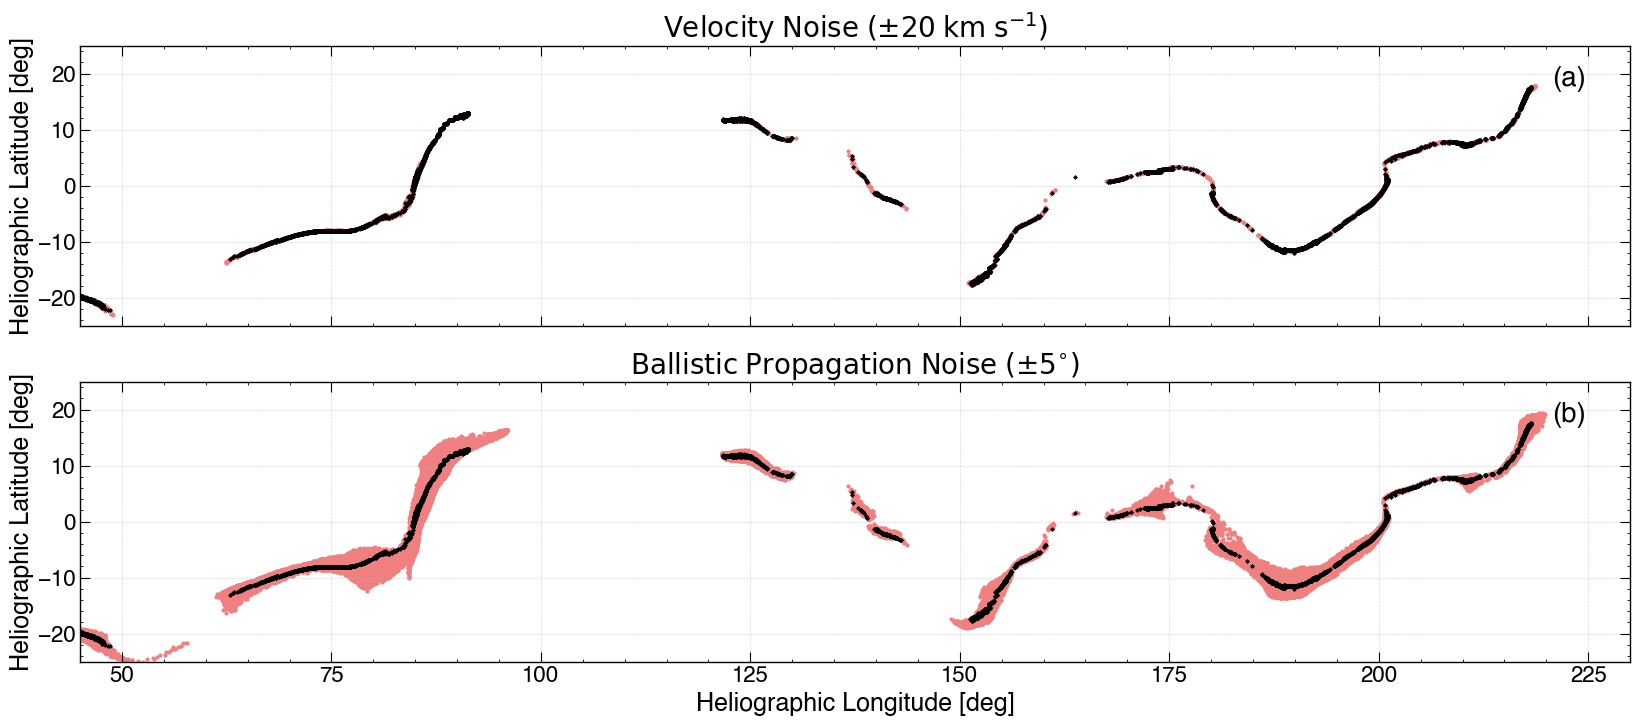

In [28]:
### FIGURE SETUP ###
fig, axs = plt.subplots(2, figsize=[20, 8], sharex='all')
pfss_col = ['tab:blue', 'tab:orange', 'black', 'tab:purple', 'tab:green']
panel_labels = ['(a)', '(b)', '(c)']

##### ---------- PANEL (A): VELOCITY NOISE FOOTPOINTS  ---------- ######
ax = axs[0]
ax.scatter(flines_psp.open_field_lines.solar_feet.lon.value, flines_psp.open_field_lines.solar_feet.lat.value, c='k', s=4, marker='D', edgecolor='k', lw=0.5) 
for i, ll in enumerate(field_lines):
    ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4, zorder=-2) 
ax.set_title(r'$\rm Velocity \; Noise \; (\pm 20 \; km \; s^{-1})$', fontsize=20)
ax.set_ylabel('Heliographic Latitude [deg]', fontsize=18)
    
##### ---------- PANEL (B): SOURCE SURFACE NOISE FOOTPOINT COMPARISON  ---------- ######
ax = axs[1]
ax.scatter(flines_psp.open_field_lines.solar_feet.lon.value, flines_psp.open_field_lines.solar_feet.lat.value, c='k', s=4, marker='D', edgecolor='k', lw=0.5) 
for i, ll in enumerate(field_lines_ss):
    ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4, zorder=-2)
ax.set_title(r'$\rm Ballistic \; Propagation \; Noise \; (\pm 5^{\circ})$', fontsize=20)
ax.set_xlabel('Heliographic Longitude [deg]', fontsize=18)
ax.set_ylabel('Heliographic Latitude [deg]', fontsize=18)

for i, ax in enumerate(axs):
    # axes limits
    ax.set(xlim=(45, 230), xticks=np.arange(50, 226, step=25))
    ax.set(ylim=(-25, 25), yticks=np.arange(-20, 21, step=10))
    # tick params
    ax.tick_params(axis='both', which='major', labelsize=16) 
    # add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # panel labels
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# save figure
fig.savefig('eps_figures/fig10.eps', bbox_inches='tight') #EPS
fig.savefig('figures/fig10.png', bbox_inches='tight') #EPS

# Plotting Function

In [14]:
def plot_pfss(smap, hcs, source_surface, flines, datetimes, ax, nf=8, dim=[0, 360, -90, 90], tm=7, dd=True, yl=True, fp=True, full=True):

    # plot on axes
    plt.sca(ax)
    
    # color dictionary
    color_dict = {-1:"blue", 0:"black", 1:"red"}
    
    # plot euv map
    if type(smap) == sunpy.map.mapbase.GenericMap:
        lons = np.linspace(0, 360, 721)
        lats = np.linspace(-90, 90, 361)
        lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(smap.data.flatten(),10
                                                           ), 
                                vmax=np.nanpercentile(smap.data.flatten(),99.9))
        ax.pcolormesh(lons, lats, smap.data, cmap='sdoaia193', norm=lognorm, zorder=-1)
    else:
        lons = np.linspace(0, 360, 361)
        lats = np.linspace(-90, 90, 181)
        ax.pcolormesh(lons,lats,topologies,cmap="coolwarm", zorder=-1)
        

    if full:
        # plot HCS
        ax.plot(hcs.lon, hcs.lat, color='white', label='HCS', zorder=0)
        # plot field lines
        for f in flines_psp[::nf] :
            fcoords = f.coords
            fcoords.representation_type="spherical"
            ax.plot(fcoords.lon,
                    fcoords.lat,
                    # fcoords.z.to("R_sun"),
                    color = color_dict.get(f.polarity), 
                    linewidth=0.5, alpha=0.5, zorder=1
                )

        # plot trajectory
        polarity = np.sign(parker.BrR2)
        pos = np.where(polarity == 1)
        neg = np.where(polarity == -1)
        ax.scatter(source_surface.lon[neg], source_surface.lat[neg], color='navy', label='Negative Polarity', zorder=2, s=3)
        ax.scatter(source_surface.lon[pos], source_surface.lat[pos], color='darkred',label='Positive Polarity', zorder=3, s=3)

    # plot errors in footpoints
    # for i, ll in enumerate(field_lines_ss):
    #     ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4)

    # add regions of interest
    lon_footpoints = flines.open_field_lines.source_surface_feet.lon.value[::nf]
    lat_footpoints = flines.open_field_lines.source_surface_feet.lat[::nf]
    fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
    slow = np.logical_and(lon_footpoints >= ssw[0], lon_footpoints <=ssw[1])
    salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])

    # plot footpoints
    lon_footpoints = flines.open_field_lines.solar_feet.lon.value[::nf]
    lat_footpoints = flines.open_field_lines.solar_feet.lat[::nf]
    ax.scatter(lon_footpoints, lat_footpoints, s=6, color='grey', marker='D')
    ax.scatter(lon_footpoints[fast], lat_footpoints[fast], s=6, color=fcol, marker='D')
    ax.scatter(lon_footpoints[slow], lat_footpoints[slow], s=6, color=scol, marker='D')
    ax.scatter(lon_footpoints[salf], lat_footpoints[salf], s=6, color=sacol, marker='D')

    # plot dates
    if dd:
        dates = [i.date() for i in datetimes]
        dates_str = [d.strftime('%m-%d-%Y') for d in dates]
        psp_inds = [np.where(np.array(dates_str) == d)[0][0] for d in np.unique(dates_str)[1:]]
        labels = np.unique(dates_str)[1:]
        for i, x in enumerate(list(zip(psp_at_source_surface.lon[psp_inds], psp_at_source_surface.lat[psp_inds]))):
            label = labels[i]
            ax.text(x[0].value - 2, x[1].value + 2, label[:-5], ha="center", va="bottom", color='white', rotation=45, size='large', zorder=5)

    # footpoints legend
    if fp:
        fleg = mpatches.Patch(color=fcol, label=r'$\rm Fast \; Wind$')
        saleg = mpatches.Patch(color=sacol, label=r'$\rm Slow \; Alfv\'enic \; Wind$')
        sleg = mpatches.Patch(color=scol, label=r'$\rm Classical \; Slow \; Wind$')
        footpoints = mpatches.Patch(color='grey', label=r'$\rm Footpoints$')
        leg2 = ax.legend(handles=[footpoints, fleg, sleg, saleg], loc='upper right')
        ax.add_artist(leg2)

    # title and labels
    ax.set_xlim((dim[0], dim[1]))
    ax.set_ylim((dim[2], dim[3]))
    ax.set_xticks(np.linspace(dim[0], dim[1], tm))
    ax.set_yticks(np.linspace(dim[2], dim[3], tm))
    ax.set_xlabel(r"$\rm Carrington \; Longitude \; [deg]$")
    if yl:
        ax.set_ylabel(r"$\rm Carrington \; Latitude \; [deg]$")

    return ax

## Footpoint Brightness

In [16]:
#### FOOTPOINTS
lats = np.array(flines_psp.open_field_lines.solar_feet.lat)
lons = np.array(flines_psp.open_field_lines.solar_feet.lon.value)


##### ---------- FOOTPOINT BRIGHTNESS  ---------- ######
sunpy_map = sunpy.map.Map(os.path.join(STORAGE_DIR, 'E11_14days.fits'))

# Convert latitude and longitude arrays to SkyCoord
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=sunpy_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sunpy_map.wcs)

# Extract data values from SunPy map at pixel coordinates
I00 = sunpy_map.data[(pixel_coords_y).astype(int), (pixel_coords_x).astype(int)]

##### ---------- FOOTPOINT FIELD STRENGH  ---------- ######
smap = gong_map

# Convert latitude and longitude arrays to SkyCoord
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=smap.coordinate_frame)

# footpoint magnetic field
pixel_coords = coords.to_pixel(smap.wcs)
B0 = smap.data[pixel_coords[1].astype(int), pixel_coords[0].astype(int)]

##### ---------- SOURCE SURFACE FIELD STRENGTH  ---------- ######
#### FOOTPOINTS
lats = np.array(flines_psp.open_field_lines.source_surface_feet.lat)
lons = np.array(flines_psp.open_field_lines.source_surface_feet.lon.value)

### FIELD STRENGTH
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=smap.coordinate_frame)
pixel_coords = coords.to_pixel(smap.wcs)
Bss = smap.data[pixel_coords[1].astype(int), pixel_coords[0].astype(int)]

##### ---------- OPEN FLUX EXPANSION  ---------- ######
use = np.where(flines_psp.connectivities == 1)[0]
f = (u.Rsun/(psp_carrington[use].radius).to(u.R_sun)) ** 2 * (B0/parker.Br[use])
fss = (u.Rsun/(flines_psp.open_field_lines.source_surface_feet.radius).to(u.R_sun)) ** 2 * (B0/Bss)


# INDIVIDUAL REGIONS

In [18]:
lon_footpoints = parker.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
# slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

In [20]:
### SDO IMAGE

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.visualization.colormaps as cm

from sunpy.map.header_helper import make_heliographic_header
from astropy.coordinates import SkyCoord



In [21]:
# data parameters
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2022-02-28T12:00:00'  # start date of query
end_date = '2022-03-02T12:00:00'  # end date of query

# AIA specific parameters
aia_inst = a.Instrument.aia
# list of all available wavelengths for reference
wavelength_list = [a.Wavelength(94 * u.angstrom), a.Wavelength(131 * u.angstrom), a.Wavelength(171 * u.angstrom),
                   a.Wavelength(193 * u.angstrom), a.Wavelength(211 * u.angstrom), a.Wavelength(304 * u.angstrom),
                   a.Wavelength(335 * u.angstrom), a.Wavelength(1600 * u.angstrom), a.Wavelength(1700 * u.angstrom)]

# HMI specific parameters
hmi_inst = a.Instrument.hmi
# list of physical observables available
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
print(file_download)
# map_seq = sunpy.map.Map(sorted(file_download))

08-Jan-24 14:27:41: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/sunpy/net/vso/vso.py:238: SunpyUserWarning: VSO-C500 :soap:Server.Transport : 500 Internal Server Error
  warn_user(resp["error"])



Files Downloaded: 0file [00:00, ?file/s]

[]


#### FAST WIND

In [13]:
### FIND TIME WHEN PLASMA LEFT SURFACE
use = np.logical_and(parker.lon >= fsw[0], parker.lon <=fsw[1])
times = parker.Time[use]
vels = parker.vr[use] * u.km/u.s
rads = (np.array(parker.radius[use]) * u.au).to(u.km)

deltaT = np.array(rads / vels)
Tsun = [timestamp - datetime.timedelta(seconds=seconds) for timestamp, seconds in zip(times, deltaT)]

fsw_times = pd.DataFrame(data={'Tparker': times, 'Tsun':Tsun, 'vr': vels})
fsw_times

,Tparker,Tsun,vr
2689,2022-02-24 15:43:17,2022-02-24 03:02:59.539387,284.531809
2690,2022-02-24 15:43:55,2022-02-24 02:39:29.485656,275.721558
2691,2022-02-24 15:44:33,2022-02-24 03:39:59.901770,298.445158
2692,2022-02-24 15:45:11,2022-02-24 02:55:48.265107,280.999269
2693,2022-02-24 15:45:49,2022-02-24 02:57:37.159939,281.374190
...,...,...,...
3580,2022-02-25 01:25:57,2022-02-24 16:42:37.938727,343.129197
3581,2022-02-25 01:26:35,2022-02-24 17:24:59.040279,372.781311
3582,2022-02-25 01:27:13,2022-02-24 16:09:59.373716,322.125208
3583,2022-02-25 01:27:51,2022-02-24 16:10:09.425834,321.794629


In [ ]:
# data parameters
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2022-02-28T12:00:00'  # start date of query
end_date = '2022-03-02T12:00:00'  # end date of query

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
map_seq = sunpy.map.Map(sorted(file_download))

Text(0.5, 1.0, 'Fast Wind Region')

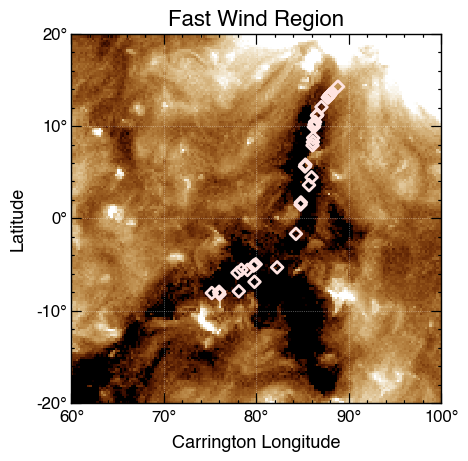

In [16]:
### FAST WIND!!!!
### SUBMAP CREATION
hmi_map = map_seq[1]
shape = (720, 1440)
carr_header = make_heliographic_header(hmi_map.date, hmi_map.observer_coordinate, shape, frame='carrington')
outmap = hmi_map.reproject_to(carr_header)
bottom_left = SkyCoord(60*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
fsw_submap = outmap.submap(bottom_left, width=40*u.degree, height=40*u.degree)
fig = plt.figure()
ax = fig.add_subplot(projection=fsw_submap)

### FIGURE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw_submap.data.flatten(),10), 
                        vmax=np.nanpercentile(fsw_submap.data.flatten(),95))
fsw_submap.plot(axes=ax, norm=lognorm)
coords = SkyCoord(lon=np.array(pfss.flon[fast][::3])*u.deg, lat=np.array(pfss.flat[fast][::3])*u.deg, frame=fsw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)
ax.set_title('Fast Wind Region')

#### SLOW ALFVENIC WIND

In [23]:
### FIND TIME WHEN PLASMA LEFT SURFACE
use = np.logical_and(parker.lon >= sasw[0], parker.lon <=sasw[1])
times = parker.Time[use]
vels = parker.vr[use] * u.km/u.s
rads = (np.array(parker.rAU[use]) * u.au).to(u.km)

deltaT = np.array(rads / vels)
Tsun = [timestamp - datetime.timedelta(seconds=seconds) for timestamp, seconds in zip(times, deltaT)]

salf_times = pd.DataFrame(data={'Tparker': times, 'Tsun':Tsun, 'vr': vels})
salf_times

,Tparker,Tsun,vr
Time,,,
2022-02-26 17:21:06.345151,2022-02-26 17:21:06.345151,2022-02-26 10:57:40.866196,584.70420
2022-02-26 17:21:09.840452,2022-02-26 17:21:09.840452,2022-02-26 10:59:42.436368,587.73150
2022-02-26 17:21:13.335693,2022-02-26 17:21:13.335693,2022-02-26 10:55:31.088230,581.27010
2022-02-26 17:21:16.830934,2022-02-26 17:21:16.830934,2022-02-26 10:00:45.611278,508.94907
2022-02-26 17:21:20.326234,2022-02-26 17:21:20.326234,2022-02-26 06:23:13.883802,340.68384
...,...,...,...
2022-02-27 06:09:14.894436,2022-02-27 06:09:14.894436,2022-02-26 10:41:49.375461,240.50493
2022-02-27 06:09:18.389677,2022-02-27 06:09:18.389677,2022-02-26 10:28:42.974878,237.82672
2022-02-27 06:09:21.884977,2022-02-27 06:09:21.884977,2022-02-26 10:34:34.698476,239.00537


In [24]:
# data parameters
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2022-02-25T12:00:00'  # start date of query
end_date = '2022-02-27T12:00:00'  # end date of query

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
map_seq = sunpy.map.Map(sorted(file_download))

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

08-Jan-24 14:29:02: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1424865643-1424865643 failed to download with exception
Download Failed: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1424865643-1424865643 with error <ClientResponse(https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1424865643-1424865643) [500 Internal Server Error]>
<CIMultiDictProxy('Date': 'Mon, 08 Jan 2024 22:28:49 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'Content-Length': '541', 'Connection': 'close', 'Content-Type': 'text/html; charset=iso-8859-1')>

08-Jan-24 14:29:02: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1424952043-1424952043 failed to download with exception
Download Failed: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;rec

2/0 files failed to download. Please check `.errors` for details


RuntimeError: No maps loaded

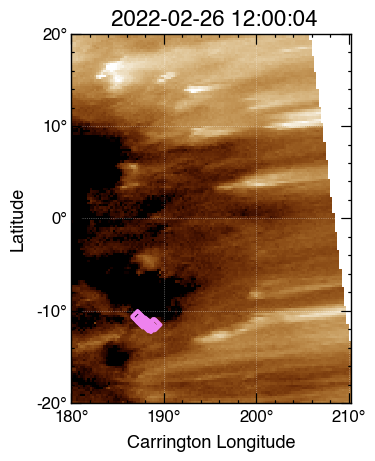

In [20]:
### SLOW ALFVENIC WIND!!!!
### MAP CREATION
hmi_map = map_seq[0]
shape = (720, 1440)
carr_header = make_heliographic_header(hmi_map.date, hmi_map.observer_coordinate, shape, frame='carrington')
outmap = hmi_map.reproject_to(carr_header)
### CREATE SUBMAP
bottom_left = SkyCoord(180.01*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
sasw_submap = outmap.submap(bottom_left, width=30*u.degree, height=40*u.degree)
bottom_left = SkyCoord(160*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
sasw_submap2 = outmap.submap(bottom_left, width=20*u.degree, height=40*u.degree)
fig = plt.figure()
ax = fig.add_subplot(projection=sasw_submap)

### PLOT FIGURE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(sasw_submap.data.flatten(),10), 
                        vmax=np.nanpercentile(sasw_submap.data.flatten(),99.9))
sasw_submap.plot(axes=ax, norm=lognorm)
# sasw_submap2.plot(axes=ax, norm=lognorm)
coords = SkyCoord(lon=np.array(pfss.flon[salf])*u.deg, lat=np.array(pfss.flat[salf])*u.deg, frame=sasw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sasw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=sacol, linewidth=2)

# ax.set_title('Slow Alfvenic Wind Region')

# Individual Wind Stream

22-Nov-23 15:56:03: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
22-Nov-23 15:56:03: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


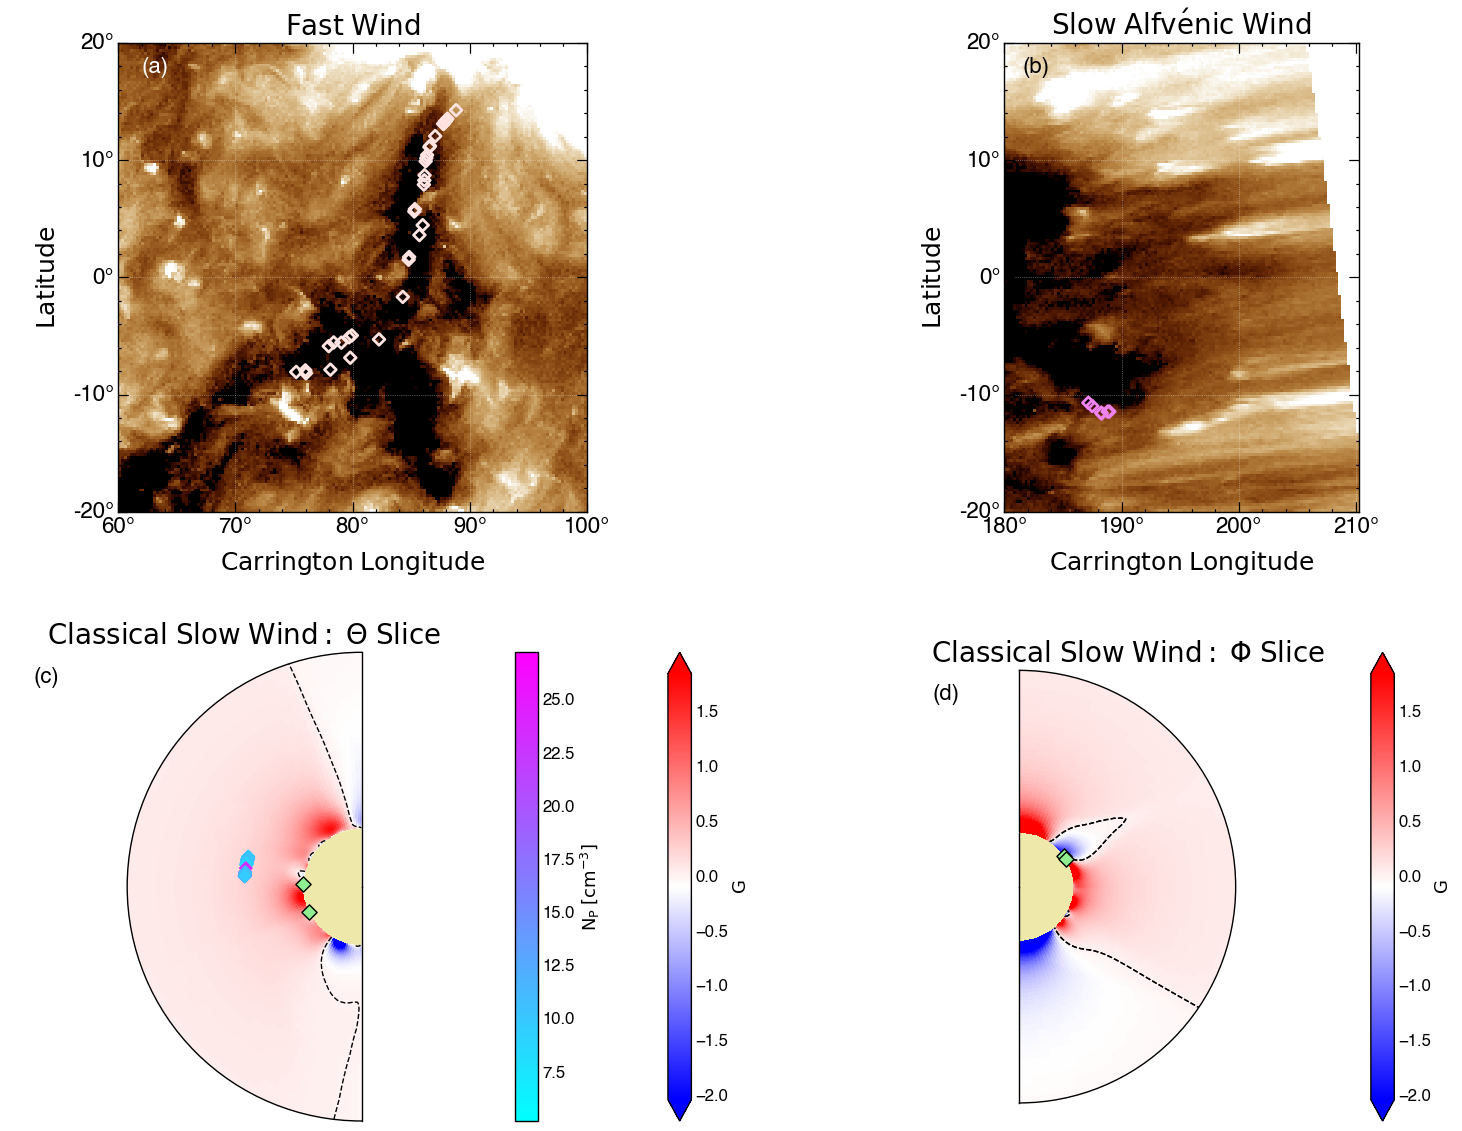

In [27]:
### SETUP FIGURE
fig = plt.figure(figsize=(20, 14))
fig.tight_layout()
grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.15, width_ratios=[2, 1.2]) #height_ratios=[1, 1, 3], 
nf = 16
pdatetimes = parker.Time

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, 0], projection=fsw_submap)
ax2 = fig.add_subplot(grid[0, 1], projection=sasw_submap)
ax3 = fig.add_subplot(grid[1, 0],  projection='polar')
ax4 = fig.add_subplot(grid[1, 1], projection='polar')
# ax5 = fig.add_subplot(grid[2, :])
axs = [ax1, ax2, ax3, ax4]

### REGION IDENTIFICATION
lon_footpoints = pfss.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

##### ---------- PANEL (A): FAST WIND REGION  ---------- ######
ax = ax1
### IDENTIFY FOOTPOINTS
lon_footpoints = pfss.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])

### PLOT AIA IMAGE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw_submap.data.flatten(),10), 
                        vmax=np.nanpercentile(fsw_submap.data.flatten(),95))
fsw_submap.plot(axes=ax, norm=lognorm)

### PLOT FOOTPOINTS
coords = SkyCoord(lon=np.array(pfss.flon[fast][::3])*u.deg, lat=np.array(pfss.flat[fast][::3])*u.deg, frame=fsw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)

# ### ADD ERROR
# for i, ll in enumerate(field_lines_ss):
#     coords = SkyCoord(lon=np.array(ll.open_field_lines.solar_feet.lon[fast])*u.deg, lat=np.array(l.open_field_lines.solar_feet.lat[fast])*u.deg, frame=fsw_submap.coordinate_frame)
#     pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw_submap.wcs)
#     ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)

### PLOT TITLE
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\rm Carrington \; Longitude$', fontsize=18)
ax.set_ylabel(r'$\rm Latitude$', fontsize=18)
ax.set_title(r'$\rm Fast \; Wind$', fontsize=20)

##### ---------- PANEL (B): SLOW ALFVENIC WIND  ---------- ######
ax = ax2
### IDENTIFY FOOTPOINTS
lon_footpoints = pfss.sslon
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])

### PLOT AIA IMAGE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(sasw_submap.data.flatten(),10), 
                        vmax=np.nanpercentile(sasw_submap.data.flatten(),97))
sasw_submap.plot(axes=ax, norm=lognorm)

### PLOT FOOTPOINTS
coords = SkyCoord(lon=np.array(pfss.flon[salf][::3])*u.deg, lat=np.array(pfss.flat[salf][::3])*u.deg, frame=sasw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sasw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=sacol, linewidth=2)

### TITLE 
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\rm Carrington \; Longitude$', fontsize=18)
ax.set_ylabel(r'$\rm Latitude$', fontsize=18)
ax.set_title(r'$\rm Slow \; Alfv\'enic \; Wind$', fontsize=20)

##### ---------- PANEL (C): SLOW WIND MHD SLICE ---------- ######
ax = ax3

### SETUP FIGURE
br = corona_model["br"]
brR2 = br.radial_normalized(2)
norm = mpl.colors.Normalize(vmin=np.nanpercentile(brR2.data,15), 
                                    vmax=np.nanpercentile(brR2.data,85))
plot_theta_cut(corona_model['br'], 46, ax=ax, norm=norm, cmap='bwr')
contour_theta_cut(corona_model['br'], 46, levels=[0], ax=ax, colors="black", linestyles="--", linewidths=1)
ax.set_rmax(4)
# ax.set_rmin(12)
ax.set_rticks([])
ax.set_thetamin(90)
ax.set_thetamax(270)

### THE SUN
theta = np.linspace(0, 2*np.pi, 100)
rad = [0.99]*100  # Radius is constant at 0.99 Rsun
ax.fill_between(theta, 0, rad, color='palegoldenrod', zorder=-1)

### PLOT TRAJECTORY
op = np.where(flines_psp.connectivities == 1)[0]
sslon = psp_at_source_surface.lon.value # flines_psp.open_field_lines.source_surface_feet.lon.value
fl_slow = np.logical_and(sslon>=165, sslon<=175)
nf=2
im = ax.scatter(np.deg2rad(psp_at_source_surface.lon.value)[fl_slow][::nf], psp_at_source_surface.radius.to(u.Rsun).value[fl_slow][::nf], c=parker.pdens[fl_slow][::nf], cmap='cool', s=40, marker='D', zorder=3)

### PLOT MHD FOOTPOINTS
mlon = tracerdf.p*u.rad.to(u.deg)
mlat = 90 - tracerdf.t*u.rad.to(u.deg)
use = np.logical_and(mlat>=-6, mlat <=-5)
ax.scatter(mlon[use], tracerdf.r[use], c=scol, s=60, label=r'$\rm MHD \; Results$', marker='D', edgecolor='k', lw=1, zorder=5) # MHD

### ADD COLORBAR
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\rm N_P \; [cm^{-3}]$')

### TITLE AND LABELS
ax.set_title(r'$\rm Classical \; Slow \; Wind: \; \Theta \; Slice$', fontsize=20)
ax.set_yticklabels([])

##### ---------- PANEL (D): LASCO CORONAGRAPH ---------- ######
ax = ax4
### SETUP FIGURE
br = corona_model["br"]
brR2 = br.radial_normalized(2)
norm = mpl.colors.Normalize(vmin=np.nanpercentile(brR2.data,15), 
                                    vmax=np.nanpercentile(brR2.data,85))
corona_model['br'].plot_phi_cut(90, ax=ax, norm=norm, cmap='bwr')
corona_model['br'].contour_phi_cut(90, levels=[0], ax=ax, colors="black", linestyles="--", linewidths=1)

ax.set_rmax(4)
# ax.set_rmin(12)
ax.set_rticks([])
# ax.set_thetamin(90)
# ax.set_thetamax(270)

### THE SUN
theta = np.linspace(0, 2*np.pi, 100)
rad = [0.99]*100  # Radius is constant at 0.99 Rsun
ax.fill_between(theta, 0, rad, color='palegoldenrod', zorder=-1)

### PLOT MHD FOOTPOINTS
mlon = tracerdf.p*u.rad.to(u.deg)
mlat = 90 - tracerdf.t*u.rad.to(u.deg)
use = np.logical_and(mlat>=-6, mlat <=-5)
ax.scatter(mlat[use], tracerdf.r[use], c=scol, s=60, label=r'$\rm MHD \; Results$', marker='D', edgecolor='k', lw=1, zorder=5) # MHD

### TITLE AND LABELS
ax.set_title(r'$\rm Classical \; Slow \; Wind: \; \Phi \; Slice$', fontsize=20)
ax.set_yticklabels([])

##### ---------- PANEL LABELS  ---------- ######
ax1.text(0.05, 0.97, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.05, 0.97, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax3.text(0.05, 0.97, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax4.text(0.05, 0.97, '(d)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')

### SAVE FIGURE
fig.savefig('figures/fig7.png', bbox_inches='tight') #PNG
fig.savefig('eps_figures/fig7.eps', bbox_inches='tight') #PDF

# Figure 6: Full Magnetic Field Model

In [13]:
### SETUP FIGURE
fig = plt.figure(figsize=(18, 12))
fig.tight_layout()
grid = plt.GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0) #height_ratios=[1, 1, 3], 
nf = 16
pdatetimes = parker.Time

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
nf = 16
pdatetimes = parker.Time

##### ---------- PANEL (A): PFSS FIGURE  ---------- ######
ax = ax1
### READ IN EUV MAP
synoptic = '/Users/tamarervin/publications/e11_conjunction/results/E11_14days.fits'
smap = sunpy.map.Map(synoptic)

### PLOT PFSS MODEL
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax, nf=20, dim=[0, 240, -90, 90])
ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_ylabel(r'$\rm Carrington \; Latitude \; [deg]$', fontsize=18)

### FSW RECTANGLE
rect = mpl.patches.Rectangle((60, -20), 40, 40, linewidth=5, edgecolor=fcol, facecolor='none')
ax.add_patch(rect) 
ax.text(60, -25, 'Fig. 7: Panel (a)', fontsize=20, fontweight='bold', va='top', ha='left', color='white')

### SASW RECTANGLE
rect = mpl.patches.Rectangle((180, -20), 30, 40, linewidth=5, edgecolor=sacol, facecolor='none')
ax.add_patch(rect) 
ax1.text(180, 32, 'Fig. 7: Panel (c)', fontsize=20, fontweight='bold', va='top', ha='left', color='k')
ax1.sharex(ax3)

### LONGITUDE AND LATITUDE SLICE
ax1.axhline(-3.15, color='tomato', lw=3, linestyle='dashed', zorder=10)
ax1.axvline(180, color='gold', lw=3, linestyle='dashed', zorder=10)

##### ---------- FOOTPOINT FIELD STRENGTH ---------- ######
axf = ax2
ss=40
nf=32

### REGIONS
lon_footpoints = flines_psp.open_field_lines.source_surface_feet.lon.value[::nf]
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

### DATA
d1 = flines_psp.open_field_lines.solar_feet.lon.value[::nf]
d2 = np.abs(B0[::nf]*1e5)
axf.scatter(d1, d2, c='grey', s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast], d2[fast], c=fcol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[slow], d2[slow], c=scol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[salf], d2[salf], c=sacol, s=ss, linewidth=0.8, edgecolor='k')
# axf.scatter(d1[hhcs], d2[hhcs], c=hcol, s=ss, linewidth=0.8, edgecolor='k')

### LABELS 
axf.set(ylim=(-12.5, 112.5), yticks=np.arange(0, 101, step=25))
axf.set_ylabel(r'$\rm |B_0| \;  [G]$', fontsize=18)
axf.axhline(1, color='k', linestyle='dashed', zorder=-1)
axf.tick_params(axis='both', which='major', labelsize=16) 
axf.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axf.set_xticklabels([])
axf.sharex(ax3)

##### ---------- RELATIVE FOOTPOINT BRIGHTNESS  ---------- ######
axf = ax3
nf=16
d1 = flines_psp.open_field_lines.solar_feet.lon.value[0::nf]
use = np.where(flines_psp.connectivities==1)[0]
d2 = flines_psp.expansion_factors[use][0::nf]
lon_footpoints = flines_psp.open_field_lines.source_surface_feet.lon.value[::nf]
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

### PLOT DATA
axf.scatter(d1, d2, c='grey', s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast], d2[fast], c=fcol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[slow], d2[slow], c=scol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[salf], d2[salf], c=sacol, s=ss, linewidth=0.8, edgecolor='k')
# axf.scatter(d1[hhcs], d2[hhcs], c=hcol, s=ss, linewidth=0.8, edgecolor='k')

### LIMITS AND LABELS
# axf.set(ylim=(-, 125), yticks=np.arange(-100, 101, step=50))
axf.set_yscale('log')
axf.tick_params(axis='both', which='major', labelsize=16) 
axf.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axf.set_ylabel(r'$\rm f_{ss}$', fontsize=18)
axf.set_xlabel(r'$\rm Carrington \; Longitude \; [deg]$', fontsize=18)
axf.set(xlim=(25, 225), xticks=np.arange(50, 201, step=25))

##### ---------- PANEL LABELS  ---------- ######
ax1.text(0.02, 0.93, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax2.text(0.02, 0.93, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax3.text(0.02, 0.93, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
# ax4.text(0.05, 0.93, '(e)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')

### SAVE FIGURE
fig.savefig('eps_figures/fig6.eps', bbox_inches='tight') #EPS
fig.savefig('eps_figures/fig6.pdf', bbox_inches='tight') #EPS
fig.savefig('figures/fig6.png', bbox_inches='tight') #EPS

05-Dec-23 16:24:42: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
